In [1]:
import os
import numpy as np
import torch
import pyedflib
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import torch.nn as nn
import torch.nn.functional as F

# 고정 설정
sampling_rate = 256
segment_length = 30 * sampling_rate
label_map = {
    'Sleep stage W': 0,
    'Sleep stage N1': 1,
    'Sleep stage N2': 1,
    'Sleep stage N3': 3,
    'Sleep stage R': 4
}
root_dir = "/home/mhb0917/캡스톤디자인/sleep/recordings"


In [2]:
def load_data_from_sn(sn_list):
    all_segments = []
    all_labels = []

    for sn in sn_list:
        base = f"SN{sn:03d}"
        ecg_path = os.path.join(root_dir, f"{base}.edf")
        label_path = os.path.join(root_dir, f"{base}_sleepscoring.edf")

        if not os.path.exists(ecg_path) or not os.path.exists(label_path):
            print(f"❌ 파일 없음: {base}")
            continue

        try:
            ecg_reader = pyedflib.EdfReader(ecg_path)
            ecg_signal = ecg_reader.readSignal(7)
        finally:
            ecg_reader._close()

        try:
            label_reader = pyedflib.EdfReader(label_path)
            annotations = label_reader.readAnnotations()
        finally:
            label_reader._close()

        onsets, durations, labels = annotations
        label_seq = []
        for i in range(len(labels)):
            label_str = labels[i].decode() if isinstance(labels[i], bytes) else labels[i]
            if label_str in label_map:
                label_index = label_map[label_str]
                num_segments = int(durations[i] // 30)
                label_seq.extend([label_index] * num_segments)

        # ⚠️ 반드시 가능한 segment 수 계산 후 최소로 맞춤
        max_possible_segments = len(ecg_signal) // segment_length
        num_segments = min(len(label_seq), max_possible_segments)

        ecg_segments = []
        for i in range(num_segments):
            start = i * segment_length
            end = start + segment_length
            segment = ecg_signal[start:end]
            segment = (segment - np.mean(segment)) / (np.std(segment) + 1e-8)
            ecg_segments.append(segment)

        all_segments.extend(ecg_segments)
        all_labels.extend(label_seq[:num_segments])

    # 텐서 변환
    X = torch.tensor(np.array(all_segments), dtype=torch.float32).unsqueeze(1)
    y = torch.tensor(all_labels, dtype=torch.long)
    return X, y


In [3]:
# train: SN001 ~ SN093
X_train, y_train = load_data_from_sn(list(range(1, 93)))

# validation: SN094 ~ SN123
X_val, y_val = load_data_from_sn(list(range(94, 123)))

# test: SN124 ~ SN154
X_test, y_test = load_data_from_sn(list(range(124, 154)))

print("✅ 학습 데이터:", X_train.shape, y_train.shape)
print("✅ validation 데이터:", X_train.shape, y_train.shape)
print("✅ 테스트 데이터:", X_test.shape, y_test.shape)


❌ 파일 없음: SN014
❌ 파일 없음: SN064
❌ 파일 없음: SN135
✅ 학습 데이터: torch.Size([82406, 1, 7680]) torch.Size([82406])
✅ validation 데이터: torch.Size([82406, 1, 7680]) torch.Size([82406])
✅ 테스트 데이터: torch.Size([26866, 1, 7680]) torch.Size([26866])


In [5]:
import torch
from collections import Counter

print("📊 Train 라벨 분포:", Counter(y_train.numpy()))


📊 Train 라벨 분포: Counter({np.int64(1): 39927, np.int64(3): 15415, np.int64(0): 13928, np.int64(4): 13136})


In [8]:
import torch
import numpy as np
from collections import Counter

# 라벨 numpy로 변환
y_np = y_train.numpy()
X_np = X_train.numpy()

# 라벨별 인덱스 수 세기
label_counts = Counter(y_np)
min_count = min(label_counts.values())  # 가장 작은 라벨 수 (ex: 13136)

# 균형 맞춘 인덱스 수집
balanced_indices = []
for label in sorted(label_counts.keys()):
    label_indices = np.where(y_np == label)[0]
    sampled_indices = np.random.choice(label_indices, min_count, replace=False)
    balanced_indices.extend(sampled_indices)

# 섞기
np.random.shuffle(balanced_indices)

# 샘플링된 데이터로 새 tensor 생성
X_train = torch.tensor(X_np[balanced_indices], dtype=torch.float32)
y_train = torch.tensor(y_np[balanced_indices], dtype=torch.long)

# 저장 (원한다면)
#torch.save((X_train_bal, y_train_bal), "CNN_train_balanced.pt")

# 라벨 확인
print("✅ 균형 조정 후 라벨 분포:", Counter(y_train.numpy()))


✅ 균형 조정 후 라벨 분포: Counter({np.int64(3): 13136, np.int64(0): 13136, np.int64(4): 13136, np.int64(1): 13136})


In [6]:
import torch
from collections import Counter

print("📊 Validation 라벨 분포:", Counter(y_val.numpy()))


📊 Validation 라벨 분포: Counter({np.int64(1): 11828, np.int64(0): 5066, np.int64(3): 4877, np.int64(4): 3670})


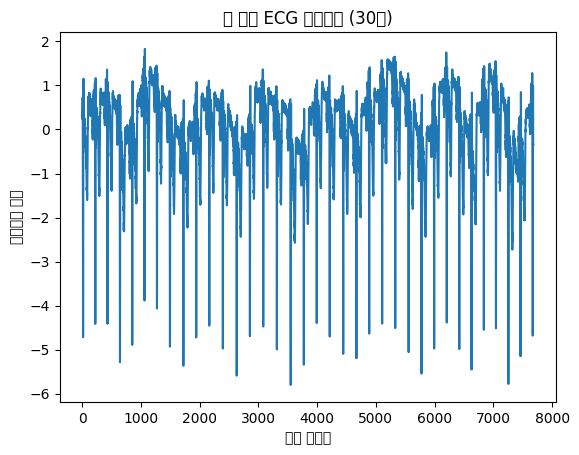

In [29]:
import matplotlib.pyplot as plt

plt.plot(X_train[12000][0][:].numpy())  # 첫 번째 세그먼트의 ECG 시계열
plt.title("첫 번째 ECG 세그먼트 (30초)")
plt.xlabel("샘플 인덱스")
plt.ylabel("정규화된 전압")
plt.show()

In [9]:
print("🧪 X_train shape:", X_train.shape)
print("🧪 y_train shape:", y_train.shape)


🧪 X_train shape: torch.Size([52544, 1, 7680])
🧪 y_train shape: torch.Size([52544])


In [10]:
class ECGSleepCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(ECGSleepCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(16)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(32)
        self.pool2 = nn.MaxPool1d(2)
        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(64)
        self.pool3 = nn.MaxPool1d(2)
        self.fc1 = nn.Linear(64 * 960, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


In [14]:
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ECGSleepCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 학습 루프
for epoch in range(50):
    model.train()
    loss_sum, correct, total = 0.0, 0, 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        outputs = model(xb)
        loss = criterion(outputs, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        _, pred = torch.max(outputs, 1)
        total += yb.size(0)
        correct += (pred == yb).sum().item()

    acc = 100 * correct / total
    print(f"📘 Epoch {epoch+1} | Loss: {loss_sum:.4f} | Acc: {acc:.2f}%")


📘 Epoch 1 | Loss: 2462.9577 | Acc: 26.70%
📘 Epoch 2 | Loss: 2284.2954 | Acc: 29.45%
📘 Epoch 3 | Loss: 2253.9358 | Acc: 30.22%
📘 Epoch 4 | Loss: 2235.6641 | Acc: 30.87%
📘 Epoch 5 | Loss: 2230.5034 | Acc: 30.92%
📘 Epoch 6 | Loss: 2220.5134 | Acc: 31.25%
📘 Epoch 7 | Loss: 2211.9873 | Acc: 31.77%
📘 Epoch 8 | Loss: 2205.4766 | Acc: 32.05%
📘 Epoch 9 | Loss: 2174.2061 | Acc: 34.37%
📘 Epoch 10 | Loss: 2156.2777 | Acc: 35.42%
📘 Epoch 11 | Loss: 2095.5517 | Acc: 36.35%
📘 Epoch 12 | Loss: 2043.3290 | Acc: 37.02%
📘 Epoch 13 | Loss: 2015.5215 | Acc: 37.38%
📘 Epoch 14 | Loss: 1990.8276 | Acc: 37.94%
📘 Epoch 15 | Loss: 1966.2463 | Acc: 38.23%
📘 Epoch 16 | Loss: 1944.9408 | Acc: 38.78%
📘 Epoch 17 | Loss: 1925.3437 | Acc: 39.28%
📘 Epoch 18 | Loss: 1907.2641 | Acc: 39.40%
📘 Epoch 19 | Loss: 1888.6268 | Acc: 39.51%
📘 Epoch 20 | Loss: 1866.1686 | Acc: 40.87%
📘 Epoch 21 | Loss: 1835.7143 | Acc: 41.48%
📘 Epoch 22 | Loss: 1823.1852 | Acc: 42.06%
📘 Epoch 23 | Loss: 1803.9415 | Acc: 42.75%
📘 Epoch 24 | Loss: 1

In [15]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for i in range(0, len(X_test), 32):
        xb = X_test[i:i+32].to(device)
        yb = y_test[i:i+32].to(device)
        outputs = model(xb)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())


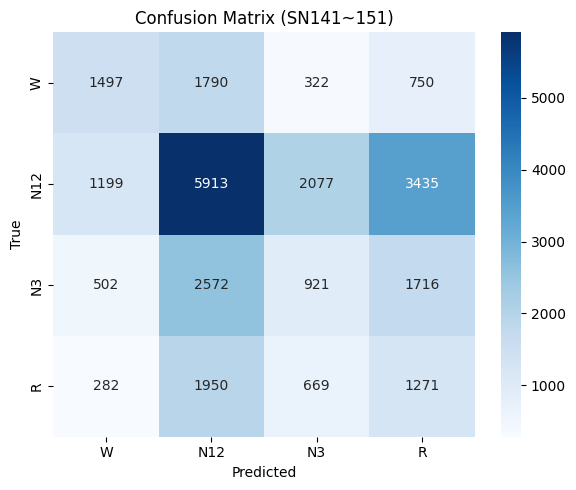

📄 Classification Report:
              precision    recall  f1-score   support

           W       0.43      0.34      0.38      4359
         N12       0.48      0.47      0.48     12624
          N3       0.23      0.16      0.19      5711
           R       0.18      0.30      0.22      4172

    accuracy                           0.36     26866
   macro avg       0.33      0.32      0.32     26866
weighted avg       0.37      0.36      0.36     26866



In [16]:
labels = ['W', 'N12', 'N3', 'R']

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (SN141~151)")
plt.tight_layout()
plt.show()

# Classification Report
print("📄 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=labels))
